## **Comparing Transfer Learning Performance of CNNs and Vision Transformers**

# Data Pre-processing

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload() # upload kaggle.json api key
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 95% 366M/385M [00:03<00:00, 31.9MB/s]
100% 385M/385M [00:04<00:00, 100MB/s] 


In [ ]:
%%capture
! ls -lh /content;
! unzip cards-image-datasetclassification.zip -d cards-dataset;

In [ ]:
!ls -lh /content/cards-dataset/

total 259M
-rw-r--r--  1 root root 130M Nov 17  2022 '14card types-14-(200 X 200)-94.61.h5'
-rw-r--r--  1 root root 130M Nov 17  2022 '53cards-53-(200 X 200)-100.00.h5'
-rw-r--r--  1 root root 469K Nov 17  2022  cards.csv
drwxr-xr-x 55 root root 4.0K Dec 11 13:33  test
drwxr-xr-x 55 root root 4.0K Dec 11 13:33  train
drwxr-xr-x 55 root root 4.0K Dec 11 13:33  valid


In [ ]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers
from keras.preprocessing.image import ImageDataGenerator


train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/cards-dataset/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224))


val_ds = keras.utils.image_dataset_from_directory(
    directory='/content/cards-dataset/valid',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224))

test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/cards-dataset/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224))

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


# Transfer Learning on ResNet50

In [ ]:
!pip install keras-tuner
import keras_tuner
from keras_tuner import RandomSearch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.4 MB/s eta 0:00:00


In [ ]:
from keras.applications import ResNet50
from keras.regularizers import l2
from keras.optimizers import Adam

def built_finetune_model(hp):
  base_model = ResNet50(
    weights ='imagenet',
    include_top = False,
    input_shape = (224,224,3),
    )
  for layer in base_model.layers:
    layer.trainable = False

  flat = base_model.output
  global_pool = keras.layers.GlobalAveragePooling2D()(flat)
  drop = keras.layers.Dropout(0.2)(global_pool)
  x = keras.layers.Flatten()(drop)

  predictions = keras.layers.Dense(53 , activation = 'softmax')(x)
  finetune_model = Model(inputs = base_model.input , outputs =  predictions)
  adam = Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4]))
  optimizer1 = hp.Choice('optimizer', values = ['adam'])
  finetune_model.compile(optimizer =optimizer1,
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

  return finetune_model

tunner2 = RandomSearch(
    built_finetune_model,
    keras_tuner.Objective("accuracy", direction="max"),
    max_trials = 5,
    executions_per_trial = 1,
    directory = './',
)
tunner2.search(
    train_ds ,
    epochs = 5 ,
    validation_data=val_ds,
    steps_per_epoch = len(train_ds)//32 ,
    validation_steps=len(val_ds),
)
tunner2.get_best_hyperparameters()[0].values
model = tunner2.get_best_models(num_models =1)[0]
model.fit(train_ds ,
    epochs = 20 ,
    validation_data=val_ds,
    steps_per_epoch = len(train_ds) ,
    validation_steps=len(val_ds),)
model.summary()


Trial 3 Complete [00h 10m 08s]
accuracy: 0.1071428582072258

Best accuracy So Far: 0.1473214328289032
Total elapsed time: 00h 33m 16s
Epoch 1/20
239/239 [==============================] - 1727s 7s/step - loss: 2.6180 - accuracy: 0.2901 - val_loss: 2.0190 - val_accuracy: 0.3811
Epoch 2/20
239/239 [==============================] - 1717s 7s/step - loss: 1.9118 - accuracy: 0.4464 - val_loss: 1.7499 - val_accuracy: 0.4415
Epoch 3/20
239/239 [==============================] - 1709s 7s/step - loss: 1.5736 - accuracy: 0.5437 - val_loss: 1.7266 - val_accuracy: 0.4642
Epoch 4/20
239/239 [==============================] - 1709s 7s/step - loss: 1.3516 - accuracy: 0.5985 - val_loss: 1.6905 - val_accuracy: 0.4755
Epoch 5/20
239/239 [==============================] - 1677s 7s/step - loss: 1.2036 - accuracy: 0.6398 - val_loss: 1.6591 - val_accuracy: 0.5057
Epoch 6/20
239/239 [==============================] - 1707s 7s/step - loss: 1.0794 - accuracy: 0.6839 - val_loss: 1.6587 - val_accuracy: 0.4906
Ep

In [ ]:
model.save("DS340.h5")

# CNN Model Evaluation

In [ ]:
from matplotlib import pyplot as plt
history = model.history

# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

AttributeError: ignored

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}")

9/9 [==============================] - 62s 7s/step - loss: 1.9738 - accuracy: 0.5358
Test accuracy: 0.5358490347862244


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_test = []

for _, label_batch in test_ds:
    y_test.extend(label_batch.numpy())
y_test = np.argmax(y_test, axis=1)


# Create the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48", "49", "50", "51", "52"])

9/9 [==============================] - 55s 6s/step


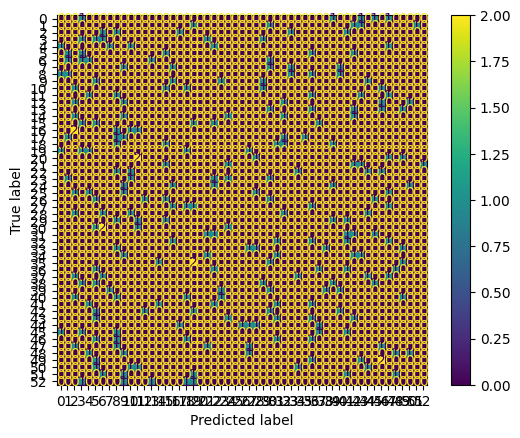

In [ ]:
disp.plot()

# Transfer Learning on ViT-Base

In [ ]:
! pip install torch torchvision
! pip install transformers

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

vit_train_ds = ImageFolder('/content/cards-dataset/train', transform=ToTensor())
train_loader = DataLoader(vit_train_ds, batch_size=32, shuffle=True)

vit_val_ds = ImageFolder('/content/cards-dataset/valid', transform=ToTensor())
val_loader = DataLoader(vit_val_ds, batch_size=32, shuffle=False)

vit_test_ds = ImageFolder('/content/cards-dataset/test', transform=ToTensor())
test_loader = DataLoader(vit_test_ds, batch_size=32, shuffle=False)

In [ ]:
from torch import nn
from transformers import ViTFeatureExtractor, ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

num_labels = 53
model.classifier = nn.Linear(model.classifier.in_features, num_labels)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

def train(model, dataloader, loss_fn, optimizer):
    total_loss = 0
    model.train()
    for batch in dataloader:
        images, labels = batch
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

def validate(model, dataloader, loss_fn):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            val_loss += loss_fn(outputs.logits, labels).item()
            predicted = outputs.logits.argmax(dim=1)
            correct += (predicted == labels).sum().item()

    val_loss /= len(dataloader.dataset)
    val_accuracy = 100 * correct / len(dataloader.dataset)
    return val_loss, val_accuracy

for epoch in range(2):
    train(model, train_loader, loss_fn, optimizer)
    val_loss, val_accuracy = validate(model, val_loader, loss_fn)
    print(f'Epoch {epoch}: Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%')

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# ViT Model Evaluation

In [ ]:
torch.save(model, 'DS340_vit_model.pth')

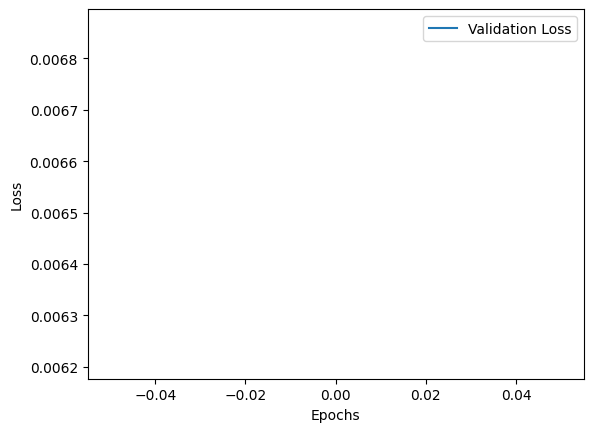

In [ ]:
from matplotlib import pyplot as plt

plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from torch.nn.functional import softmax

features = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        feature_tensor = outputs.logits
        features.append(feature_tensor)

# Concatenate all features
features = torch.cat(features, dim=0)


# Extract the predicted class index
predicted_class_idx = features.argmax(-1)
predicted_class_idx.tolist()

# You might also want to map the predicted index to a human-readable class name
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48", "49", "50", "51", "52"]
predicted_class = class_names[predicted_class_idx]

confusion_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48", "49", "50", "51", "52"])

TypeError: ignored

In [ ]:
model.load_state_dict(torch.load('DS340_vit_model.pth'))

FileNotFoundError: ignored

In [ ]:
ls

cards-dataset/  cards-image-datasetclassification.zip  sample_data/
